In [1]:
import numpy as np
import random
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import scatter, mask_to_index, index_to_mask, to_networkx
from torch_geometric.data import Data, DataLoader
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch import optim
from torch_scatter import scatter_sum, scatter_mean
import pickle
import matplotlib.pyplot as plt
import copy
from tree_util import load_merged_h5_trees, split_dataloader, dataset_to_dataloader
from model_tree import TreeGINConv, TreeRegressor, MLPAgg, DeepSet, train_eval_model, eval_and_plot, plot_train_val_loss
import argparse
import pathlib
import math
import os

import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

Pytorch Geometric is available = True. Return list of PyG.Data = True


### Load data

In [48]:
trainset_path = "/mnt/home/thuang/playground/datasets/pruned_trimmed_tree_small/pruned_trimmed_trainset_n=3_lh=600.pkl"
valset_path = "/mnt/home/thuang/playground/datasets/pruned_trimmed_tree_small/pruned_trimmed_valset_n=3_lh=200.pkl"

trainset = pickle.load(open(trainset_path, "rb"))
valset = pickle.load(open(valset_path, "rb"))


In [49]:
len(trainset)

1800

In [50]:
idx = 0
train_data = trainset[idx]

In [51]:
train_data

Data(x=[3213, 4], edge_index=[2, 3212], edge_attr=[3212, 1], y=[1, 2], num_nodes=3213, lh_id=268, mask_main=[87], node_halo_id=[3213, 1])

In [52]:
train_data.x #un-normalized features (mass, concentration, vmax, time)

tensor([[13.9151,  0.8976,  2.8666,  1.0000],
        [13.9135,  0.8951,  2.8675,  0.9888],
        [13.9099,  0.8993,  2.8681,  0.9772],
        ...,
        [10.6163,  0.2628,  2.0725,  0.1765],
        [10.5766,  0.9656,  2.1206,  0.1668],
        [10.5429,  1.0102,  2.1269,  0.1610]])

In [53]:
train_data.y #target (omega_m, sigma_8)

tensor([[0.3790, 0.7742]])

In [54]:
train_data.lh_id #lh_id = 0, 1, ..., 999 (disjoint over train/val/test)

268

In [39]:

batch_size = 1
train_loader, val_loader, _ = dataset_to_dataloader(trainset, valset, batch_size=batch_size,
                                                        normalize=True, time=True)

normalizing for mean 0 , std 1 across all trees!
train_size=1800, val_size=603, test_size=0
sampled train data view = Data(x=[3213, 4], edge_index=[2, 3212], edge_attr=[3212, 1], y=[1, 2], num_nodes=3213, lh_id=268, mask_main=[87], node_halo_id=[3213, 1])


/mnt/home/thuang/playground/.venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [42]:
train_data_norm = next(iter(train_loader))

In [43]:
train_data_norm

DataBatch(x=[565, 4], x_batch=[565], x_ptr=[2], edge_index=[2, 564], edge_attr=[564, 1], y=[1, 2], num_nodes=565, lh_id=[1], mask_main=[1], node_halo_id=[565, 1], batch=[565], ptr=[2])

In [44]:
train_data_norm.x #log -> mean/std normalized (mass, concentration, vmax)

tensor([[ 2.8716, -0.1021,  2.1946,  1.0000],
        [ 2.8673, -0.0818,  2.2077,  0.9888],
        [ 2.8599, -0.0495,  2.2083,  0.9772],
        ...,
        [-0.7886, -0.6329, -0.8749,  0.2795],
        [-0.8202, -1.0815, -0.8800,  0.2679],
        [-0.9008, -0.5924, -0.9185,  0.2567]])

In [55]:
##Advanced batching: set batch_size > 1, 
batch_size = 4
train_loader_batch, val_loader_batch, _ = dataset_to_dataloader(trainset, valset, batch_size=batch_size,
                                                        normalize=True)
train_batch = next(iter(train_loader_batch))

normalizing for mean 0 , std 1 across all trees!
train_size=1800, val_size=603, test_size=0
sampled train data view = Data(x=[3213, 3], edge_index=[2, 3212], edge_attr=[3212, 1], y=[1, 2], num_nodes=3213, lh_id=268, mask_main=[87], node_halo_id=[3213, 1])


/mnt/home/thuang/playground/.venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [56]:
train_batch

DataBatch(x=[4309, 3], x_batch=[4309], x_ptr=[5], edge_index=[2, 4305], edge_attr=[4305, 1], y=[4, 2], num_nodes=4309, lh_id=[4], mask_main=[4], node_halo_id=[4309, 1], batch=[4309], ptr=[5])

In [57]:
train_batch.x_batch

tensor([0, 0, 0,  ..., 3, 3, 3])

### Visualize trees 

In [19]:
def plot_tree(data, threshold=math.log10(3e10), title=None):
    G = to_networkx(data, to_undirected=False)
    pos = graphviz_layout(G, prog="dot")
    fig, ax = plt.subplots(dpi=200)
    
    mask_main = torch.isin(data.node_halo_id.flatten(), torch.LongTensor(data.mask_main)) #NOTE: a halo id may appear > 1 if the halo splits
    node_indices = torch.nonzero(mask_main).flatten()

    node_colors = ["red" if n in node_indices else "skyblue" for n in G.nodes()]
    
    nx.draw(G, pos=pos, with_labels=False, arrows=True, arrowsize=1,
            ax=ax, node_color=node_colors, node_size=3)
    if title is not None:
        ax.set_title(title, fontsize=20)
    fig.savefig(f"Plots_trees/{train_data.node_halo_id[0].item()}.png")

/tmp/ipykernel_999801/1136750720.py:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


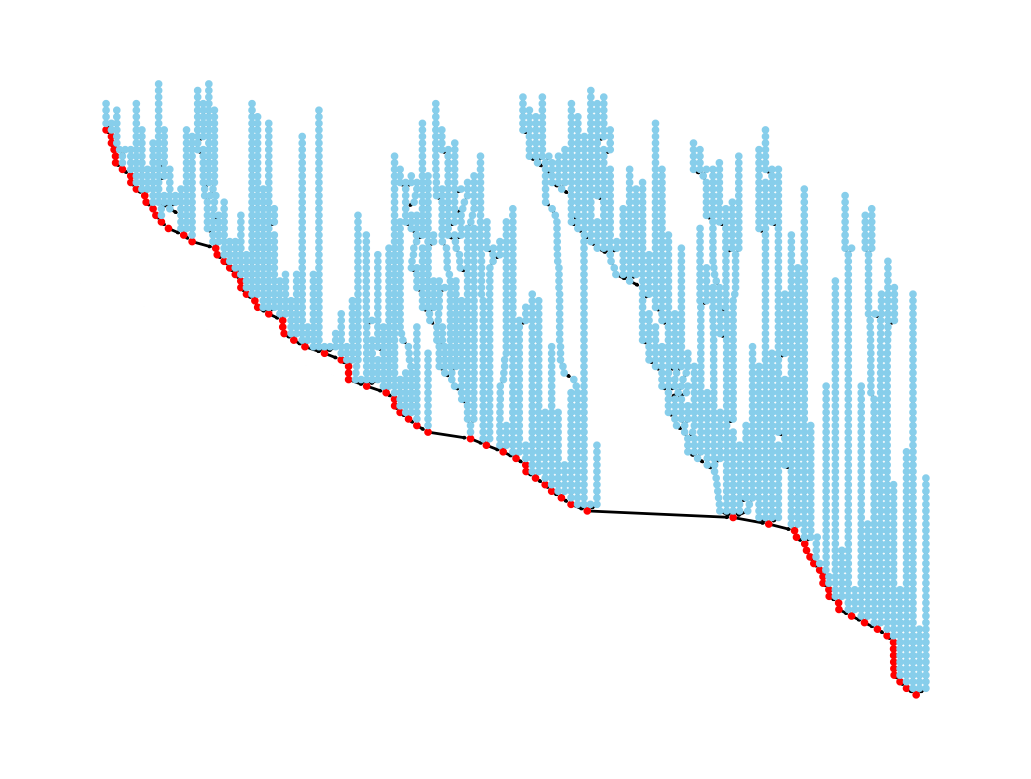

In [24]:
train_data = trainset[0]
plot_tree(train_data)